# Groupe 27
# Sergio Magalhães Contente
# Diego Pincer
# Leonardo Falabella


# Projet de classification "few shot" d'images de télédétection

## Objectifs

Les approches d'apprentissage, en particulier celles utilisant des réseaux profonds, réclament une grande quantité de données. Cette condition n'est pas toujours possible à satisfaire pour certains problèmes réels, et se pose la question de concevoir des prédicteurs avec un nombre limité de données, mais en utilisant d'autres ressources.

Il s'agit d'un problème classique d'apprentissage ayant donné lieu à un très grand nombre d'approches pour le résoudre (https://arxiv.org/abs/2205.06743). Dans le cadre du projet, on se concentrera sur l'utilisation des réseaux de neurones pré-appris à adapter.


## Position du problème

La formulation classique du problèmes est exprimée par l'expression "K-way, N-shot" qui indique que l'on cherche à construire une démarche d'apprentissage d'un classifieur à $K$ classes à parire de $N$ données.

L'évaluation de ce genre de stratégie consiste à
1. échantillonner les exemples d'apprentissage
1. réaliser l'apprentissage ou l'adaptation du classifieur à partir de ces données
1. évaluer le classifieur sur une base de test
1. recommencer la séquence et agréger les performances

Dns le cadre du projet, on dispose d'un certain nombre de réseaux de neurones profonds pré-appris sur des bases de données variées, comme ImageNet. Ces réseaux peuvent être utilisés comme extracteurs de caractéristiques d'images génériques.

Les questions que l'on se peut se poser sont les uivantes:
- Peut-on avec ces réseaux apprendre sur quelques images un nouveau classifieur pour de nouvelles classes. Typiquement, apprendre avec 5, 10, 50... exemples par classe.
- Peut-on adapter/préparer le réseau au type de données à traiter (ici des images aériennes)

## Travail

1. Récupérer les données du problème (code ci-dessus): il s'agit d'images aériennes d'un département français (ici l'Essonne). Des images d'un deuxième départment sont fournies (Haute Garonne) pour un éventuel ré-apprentissage. Les données proviennent de la base FLAIR (https://ignf.github.io/FLAIR/index_fr.html).
1. Repérer et charger des réseaux candidats pour l'extraction de caractéristiques (un exemple dans les codes ci-dessous)
1. Adapter le réseau à partir de quelques exemples: il faudra modifier le dataloader.
1. Réapprendre si besoin le réseau sur d'autres données pour préparer l'adaptation.
1. Mettre en place une démarche d'évaluation d'un apprentissage *k-shot-5-way*.Il faudra faire tourner les exemples d'apprentissage dans les dataloaders.
1. Comparer les résultats pour diverses configurations (nombre d'exemples, nature des réseaux pré-appris, réapprentissage etc.)


## Ressources disponibles
- Bibliothèques de réseaux et de datasets:
  - torchvision (https://pytorch.org/vision/stable/index.html)
  - torchgeo (https://github.com/microsoft/torchgeo)
  - hugging face (https://huggingface.co/models)
  - timm (https://timm.fast.ai/)
  - ...
- Données FLAIR
  - Images de l'Esonne pour évaluer la démarche few-shot: répertoire `D091_2021`
  - Images de la Haute-Garonne pour un complément d'apprentissage: répertoire  `D031_2019`
  - Des fichiers de labels correspondant dans le répertoire `Labels` avec comme classes

  >```
  classnames = {
        0: "Anthropized",
        1: "Natural",
        2: "Vegetation",
        3: "Agricultural",
        4: "Herbeceous"
    }
    ```

# Quelques bouts de code utiles

## Connexion au drive
il faut donner accès aux données que nous utiliserons pour construire le modèle. Pour ce faire, nous avons créé un lecteur avec l'ensemble de la base de données et l'avons lié à colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# CHANGER ICI!!
import os
os.chdir('/content/drive/MyDrive/Sergio_ENSTA')

## Bibliothèques utiles

In [ ]:
# Importe la bibliothèque PyTorch pour le machine learning et les réseaux de neurones
import torch

# Installe silencieusement 'timm' pour accéder à divers modèles de réseaux neuronaux pré-entraînés
!pip -q install timm

# Installe silencieusement 'torchgeo', une bibliothèque pour travailler avec des données géospatiales et de télédétection
!pip -q install torchgeo

# Installe silencieusement 'torchmetrics', une bibliothèque offrant des métriques pour évaluer les modèles de machine learning
!pip -q install torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.5/378.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 690.3/690.3 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 77.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 71.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
# Permet de vérifier si vous avez accès à un GPU
!nvidia-smi

Tue Jan 30 02:44:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip -q install gdown

# Téléchargement des données: prend environ 1min15 avec un bon internet
# Get Images
!gdown https://drive.google.com/uc?id=1xARXjWW6YyTfkh8oHkG5ZAYFScKXkrwL
!unzip -q FLAIR1_IGN.zip
!rm FLAIR1_IGN.zip
# Get Labels
!gdown https://drive.google.com/drive/folders/1bSi5XJ8jlnJdpNC9kmtkGqkzZ4P2aKst --folder

In [ ]:
# Importation des bibliothèques nécessaires pour le traitement des données, la construction et l'entraînement des réseaux neuronaux, et l'évaluation des modèles
# 'torch.nn', 'numpy', 'pandas', et 'random' sont utilisés pour les opérations de base et la manipulation des données
# 'seaborn' et 'matplotlib.pyplot' pour la visualisation des données
import torch.nn as nn
import numpy as np
import pandas as pd
import random
import seaborn as sns

# 'PIL.Image' pour le traitement d'images, 'torch.optim' et 'torch.nn.functional' pour l'optimisation et les fonctions de réseau neural
# 'tqdm' pour les barres de progression lors de l'entraînement
import matplotlib.pyplot as plt
from PIL import Image
from torch import optim
from torch.nn import functional as F
from tqdm import tqdm

# 'torchvision' pour les datasets et les transformations d'images, 'torch.utils.data' pour la gestion des datasets et dataloaders
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, RandomSampler, ConcatDataset

# 'torchmetrics' pour les métriques d'évaluation telles que la matrice de confusion, la précision, le rappel et l'exactitude
from torchmetrics.classification import MulticlassConfusionMatrix
from torchmetrics import ConfusionMatrix, MetricCollection, Accuracy, Precision, Recall


In [ ]:
# Configuration des paramètres d'entraînement : 'batch_size' détermine le nombre d'exemples traités simultanément lors de l'apprentissage, 'num_workers' le nombre de processus pour le chargement des données, et 'nums_epoch' le nombre de cycles complets sur l'ensemble des données d'entraînement
batch_size = 5
num_workers = 2
nums_epoch = 5

In [ ]:
# Importation de 'timm' pour les modèles de réseaux neuronaux et de 'torchgeo' pour des poids spécifiques
import timm
from torchgeo.models import ResNet50_Weights

# Configuration du modèle ResNet50 pré-entraîné avec des poids adaptés aux images Sentinel-2
# Le modèle est configuré pour travailler avec le nombre de canaux d'entrée spécifique et pour classifier en 5 classes
weights = ResNet50_Weights.SENTINEL2_RGB_SECO
class_num = 5
in_chans = weights.meta["in_chans"]

# Le modèle est chargé sur le GPU si disponible, sinon sur le CPU. Les poids sont chargés dans le modèle, même si toutes les clés ne correspondent pas exactement (strict=False)
_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model("resnet50", in_chans=in_chans, num_classes=class_num).cuda()
model.load_state_dict(weights.get_state_dict(progress=True), strict=False)

Downloading: "https://huggingface.co/torchgeo/resnet50_sentinel2_rgb_seco/resolve/main/resnet50_sentinel2_rgb_seco-018bf397.pth" to /root/.cache/torch/hub/checkpoints/resnet50_sentinel2_rgb_seco-018bf397.pth
100%|██████████| 90.0M/90.0M [00:00<00:00, 233MB/s]


_IncompatibleKeys(missing_keys=['fc.weight', 'fc.bias'], unexpected_keys=[])

In [ ]:
# Définition d'un dictionnaire pour mapper les identifiants numériques aux noms des classes de terrain
# Chaque numéro (de 0 à 4) est associé à un type de couverture du sol, utilisé pour la classification des images

classnames = {
        0: "Anthropized",
        1: "Natural",
        2: "Vegetation",
        3: "Agricultural",
        4: "Herbeceous"
    }

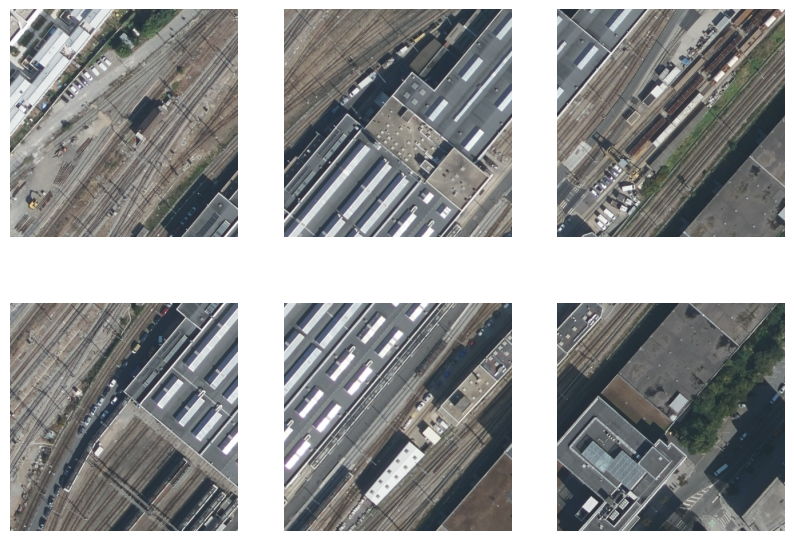

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Fonction pour charger une image à partir d'un chemin de fichier en utilisant PIL.
# Convertit l'image en format RGB.

def pil_loader(path):
    '''
    Ref:
    https://pytorch.org/docs/stable/_modules/torchvision/datasets/folder.html#ImageFolder
    '''
    with open(path, 'rb') as f: # equivalent de f.read de rasterio
       img = Image.open(f)
       return img.convert('RGB')

# Liste des chemins vers les 6 images en ESSONNE
image_paths = [
    'FLAIR1_IGN/D091_2021/IMG_060404.png',
    'FLAIR1_IGN/D091_2021/IMG_060405.png',
    'FLAIR1_IGN/D091_2021/IMG_060406.png',
    'FLAIR1_IGN/D091_2021/IMG_060414.png',
    'FLAIR1_IGN/D091_2021/IMG_060415.png',
    'FLAIR1_IGN/D091_2021/IMG_060416.png'
]

# Création d'une figure avec 2 lignes et 3 colonnes pour afficher 6 images
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

# Flatten pour itérer sur les sous-graphiques
axes = axes.flatten()

# Chargement et affichage des images
# Utilise la fonction 'pil_loader' pour charger chaque image, puis les affiche dans les sous-graphiques correspondants.
# Les axes sont désactivés pour chaque sous-graphe pour une meilleure visualisation.for i, path in enumerate(image_paths):
    img = pil_loader(path)
    axes[i].imshow(img)
    axes[i].axis('off')  # Désactiver les axes

plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

def plot_multiclass_roc_curve(true_labels, predictions, n_classes):
    """
    Trace la courbe ROC pour un modèle de classification multiclasse en utilisant l'approche Un-contre-Restes (One-vs-Rest).

    :param true_labels: Un tableau des étiquettes vraies.
    :param predictions: Un tableau des probabilités prédites pour chaque classe.
    :param n_classes: Nombre total de classes.
    """

    # Binarisation des étiquettes pour l'approche Un-contre-Restes
    true_labels_binarized = label_binarize(true_labels, classes=[*range(n_classes)])

    # Calcul de la courbe ROC et de l'aire sous la courbe pour chaque classe
    fpr = dict() # Taux de faux positifs
    tpr = dict() # Taux de vrais positifs
    roc_auc = dict() # Aire sous la courbe ROC
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Tracé de la courbe ROC pour chaque classe
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Ligne diagonale pour référence
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


# ROC Curve

La courbe ROC, qui signifie "Caractéristique de Fonctionnement du Récepteur", est un graphique utilisé pour évaluer l'efficacité d'un modèle de classification. Le principe est simple : elle montre la relation entre le taux de vrais positifs et le taux de faux positifs d'un modèle.

Imaginez que vous avez un modèle prédisant si un email est un spam ou non. Le taux de vrais positifs est la proportion des emails spam que le modèle identifie correctement. Le taux de faux positifs est la proportion des emails non-spam que le modèle identifie incorrectement comme étant du spam.

La courbe ROC trace ces deux taux sur un graphique. L'axe horizontal représente le taux de faux positifs, et l'axe vertical le taux de vrais positifs. Un modèle parfait aurait un taux de vrais positifs de 1 (ou 100%) et un taux de faux positifs de 0, formant ainsi un angle droit sur le graphique. En pratique, la courbe tend à être une ligne incurvée qui s'approche de ce point idéal.

L'objectif est d'avoir une courbe ROC qui s'éloigne le plus possible de la ligne diagonale (qui représente un modèle ne faisant pas mieux qu'une prédiction aléatoire) et se rapproche du coin supérieur gauche du graphique, indiquant un taux élevé de vrais positifs et un faible taux de faux positifs.

In [ ]:
import matplotlib.pyplot as plt

# Supposons que loss_values soit une liste des valeurs de perte enregistrées après chaque époque,
# et epochs soit une liste des numéros d'époque. Par exemple :
# loss_values = [0.5, 0.4, 0.3, 0.25, 0.2]
# epochs = [1, 2, 3, 4, 5]

def plot_loss(loss_values, epochs):
    plt.figure(figsize=(10, 5)) # Création d'une figure avec des dimensions spécifiées
    plt.plot(epochs, loss_values, label='Training Loss') # Tracé de la courbe de perte
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Cette fonction est utile pour visualiser la baisse de la perte du modèle au fil des époques,
# ce qui peut donner des indications sur la convergence et les performances du modèle lors de l'entraînement.

In [ ]:
def plot_accuracy(epochs, accuracy_values, label='Accuracy'):
    plt.figure(figsize=(10, 5)) # Création d'une figure avec des dimensions spécifiées
    plt.plot(epochs, accuracy_values, label=label, color='blue') # Tracé de la courbe de précision
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

  # Cette fonction est utile pour visualiser l'évolution de la précision du modèle au fil des époques,
  # ce qui peut fournir des informations sur les performances du modèle lors de l'entraînement


In [ ]:
from collections import defaultdict


La première modification à apporter est à la classe FlairDataset. Nous ajoutons la fonction get_random_samples pour pouvoir sélectionner les images que nous utiliserons pour l'apprentissage. Grâce à elle, nous pouvons limiter la base de données d'entraînement à N images par classe, restriction nécessaire pour la méthode Few-Shot.

In [ ]:
# Initialise le dataset avec les chemins et les transformations d'images.
# Crée un dictionnaire par classe pour faciliter l'échantillonnage aléatoire dans le cadre de l'apprentissage "few-shot".


class FlairDataset(Dataset):
    # Custom dataset for the data loader
    def __init__(self, txt_files, trsf, k_per_class, train_paths=None):
        self.k_per_class = k_per_class
        self.trsf = trsf
        self.class_dict = defaultdict(list)
        self.class_dict_pathkey = defaultdict(list)
        self.train_paths = train_paths

        for txt_file in txt_files:
            with open(txt_file, 'r') as f:
                lines = f.read().splitlines()
            for line in lines:
                path, label, _ = line.split("\t")
                label = int(label)
                self.class_dict[label].append(path)
                self.class_dict_pathkey[path].append(label)

        if train_paths == None:
            self.data = self.get_random_samples()
        else:
            self.data = self.get_validation_data(train_paths)


# Renvoie la taille du dataset

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        path = path.replace('/FLAIR1_IGN/', './FLAIR1_IGN/')
        image = self.trsf(pil_loader(path))
        label = int(label)
        return image, label

# Sélectionne un nombre limité d'exemples par classe de manière aléatoire pour l'entraînement.

    def get_random_samples(self):
        random_samples = []
        for label, image_paths in self.class_dict.items():
            if self.k_per_class is not None:
                if self.train_paths == None:
                    #if training get k random images per class
                    selected_paths = random.sample(image_paths, min(self.k_per_class, len(image_paths)))
            else:
                selected_paths = image_paths
            random_samples.extend([(path, label) for path in selected_paths])

        # print(len(random_samples))
        return random_samples

# Renvoie les données de validation en excluant les chemins d'entraînement.

    def get_validation_data(self, train_paths):
        train_paths = dict(train_paths)
        validation_dataset = { k : self.class_dict_pathkey[k] for k in set(self.class_dict_pathkey) - set(train_paths)}
        return validation_dataset

# Met à jour les chemins d'entraînement du dataset.

    def set_train_paths(self, train_paths):
        self.train_paths = train_paths

In [ ]:
# Définition des transformations à appliquer aux images pour les ensembles de données d'entraînement et de test.
# Transformations pour l'ensemble d'entraînement

train_trsf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224, antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=63/255)
])

train_trsf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224, antialias=True),
    transforms.RandomHorizontalFlip()
])

# Transformations pour l'ensemble de test

test_trsf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256, antialias=True),
    transforms.CenterCrop(224),
])

In [ ]:
# Chemins vers les fichiers de labels pour les données d'entraînement et de test
train_paths = "./Labels/D031_2019_train_labels.txt"
test_paths ="./Labels/D031_2019_test_labels.txt"

# Nombre d'exemples par classe pour l'apprentissage few-shot, nombre de workers et taille de batch
k_per_class = 5
num_workers = 2
batch_size = 5

# Pour les données d'apprentissage
# Création du dataset d'entraînement en utilisant la classe FlairDataset
train_dataset = FlairDataset(txt_files=[train_paths], trsf=train_trsf, k_per_class=k_per_class)

# DataLoader pour le dataset d'entraînement avec mélange des données (shuffle)
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True,
                                num_workers=num_workers)
# Pour les odnnées de validation
# Création du dataset de validation à partir des mêmes chemins que le dataset d'entraînement
train_paths_used = train_dataset.data
valid_dataset = FlairDataset(txt_files=[train_paths], trsf=train_trsf, k_per_class=k_per_class, train_paths=train_paths_used)

# DataLoader pour le dataset de validation
valid_loader = DataLoader(valid_dataset, batch_size=5, shuffle=True, num_workers=num_workers)

# Pour les données de test
# Création du dataset de test sans restriction sur le nombre d'exemples par classe (k_per_class=None)
test_dataset = FlairDataset(txt_files=[test_paths], trsf=test_trsf, k_per_class=None)

# DataLoader pour le dataset de test sans mélange des données (shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False,
                                       num_workers=num_workers)
# Calcul du nombre total d'images dans chaque ensemble de données
totalTrainImages = len(train_loader.dataset)
totalTestImages = len(test_loader.dataset)
totalValidImages = len(valid_loader.dataset)

# Affichage du nombre total d'images pour chaque ensemble
print(f"Total number of train images = {totalTrainImages}")
print(f"Total number of validation images = {totalValidImages}")
print(f"Total number of test images = {totalTestImages}")


Total number of train images = 25
Total number of validation images = 322
Total number of test images = 149


À ce stade, nous pouvons vérifier que nous sélectionnons correctement les images et tester en pratique comment les images sont stockées dans la mémoire de l'ordinateur.

tensor([0, 2, 3, 1, 0])
tensor([0, 0, 4, 4, 4])
tensor([1, 1, 0, 3, 4])
tensor([1, 3, 2, 2, 1])
tensor([2, 2, 4, 3, 3])


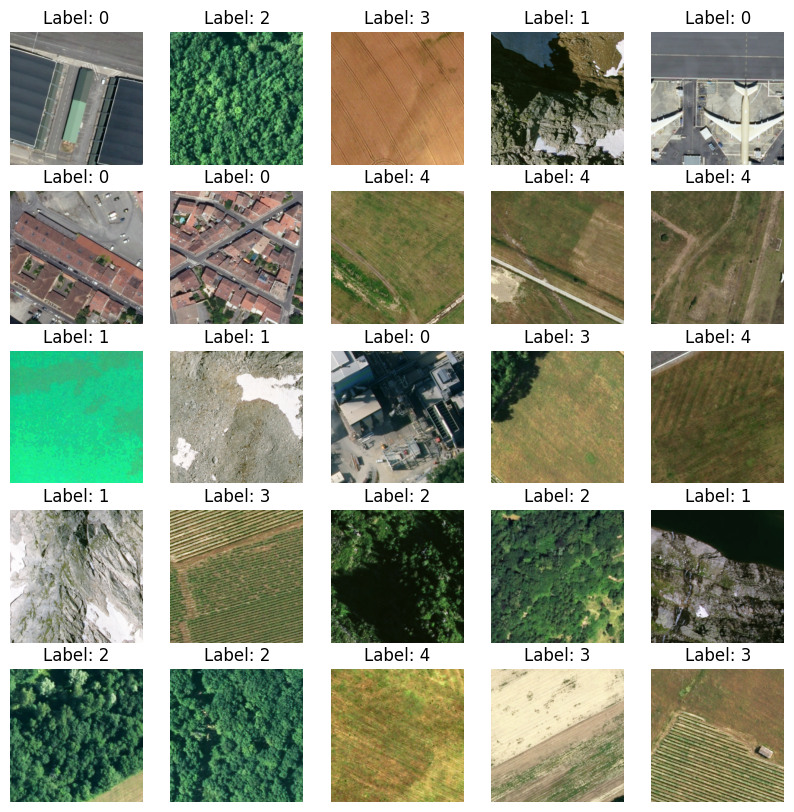

In [ ]:
import torchvision.utils as vutils

# Création d'une figure avec 5 lignes et 5 colonnes pour afficher 25 images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Flatten pour itérer sur les sous-graphiques
axes = axes.flatten()

# Chargement et affichage des images du DataLoader de l'ensemble d'entraînement
for i, (inputs, label) in enumerate(train_loader):
    print(label)
    for j, input in enumerate(inputs):
        # Utilisation de torchvision pour convertir le tensor en image et normaliser
        img = vutils.make_grid(input, normalize=True)

        # Changement de l'ordre des dimensions pour affichage avec Matplotlib
        img = img.permute(1,2,0).numpy()

        # Affichage de l'image avec son étiquette (label)
        axes[j+5*i].imshow(img)
        axes[j+5*i].set_title(f"Label: {label[j].item()}")  # Set label as title
        axes[j+5*i].axis('off')  # Désactiver les axes

plt.show()

# Entraînement avec un modèle non pré-entraîné


RESNET18

Tradicionalement, dans un problème Few-Shot, on utilise un réseau entraîné sur un problème de classification similaire à celui que l'on souhaite étudier. Pour évaluer l'influence de l'entraînement antérieur du réseau sur les performances atteintes, on analyse d'abord un modèle sans entraînement préalable. On le forme uniquement sur les exemples disponibles pour le Few-Shot et on le compare ensuite à d'autres réseaux avec entraînement préalable.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

num_classes = 5 # Nombre de classes dans le dataset
samples_per_class_train = 5 # Nombre d'exemples par classe pour l'entraînement
samples_per_class_test = 2 # Nombre d'exemples par classe pour le test

train_indices = [] # Indices pour les données d'entraînement
test_indices = [] # Indices pour les données de test

# Sélection du modèle
model = models.resnet18(weights=None) # Utilise ResNet18 sans poids pré-entraînés
for param in model.parameters():
    param.requires_grad = False # Gèle les paramètres pour ne pas les entraîner

num_ftrs = model.fc.in_features # Nombre de caractéristiques en entrée dans la dernière couche
model.fc = nn.Linear(num_ftrs, num_classes) # Remplace la dernière couche par une couche adaptée au nombre de classes

criterion = nn.CrossEntropyLoss() # Critère de perte : entropie croisée
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9) # Optimiseur : SGD

# Entraînement
num_epochs = 10
loss_vector = []
accuracy_vector = []
epochs_vector = [i for i in range(num_epochs)]
true_labels = []
predictions = []

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Passage du modèle en mode entraînement
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss_vector.append(running_loss/len(train_loader))

    # Calcul de la précision sur l'ensemble de test après chaque époque
    correct = 0
    total = 0
    model.eval()  # Passage du modèle en mode évaluation
    with torch.no_grad():
        for images, labels in test_loader:  # Utiliser idéalement un DataLoader de validation
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Accumulation des étiquettes vraies et des prédictions pour la courbe ROC
            true_labels.extend(labels.cpu().numpy())
            probabilities = torch.softmax(outputs, dim=1)
            predictions.extend(probabilities.cpu().numpy())

    epoch_accuracy = correct / total # Calcul de la précision de l'époque
    accuracy_vector.append(epoch_accuracy) # Enregistrement de la précision
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Accuracy: {epoch_accuracy}')


Epoch 1, Loss: 1.7255983352661133, Accuracy: 0.38926174496644295
Epoch 2, Loss: 1.6022897243499756, Accuracy: 0.10738255033557047
Epoch 3, Loss: 1.580165958404541, Accuracy: 0.19463087248322147
Epoch 4, Loss: 1.4675129890441894, Accuracy: 0.15436241610738255
Epoch 5, Loss: 1.5097688674926757, Accuracy: 0.0738255033557047
Epoch 6, Loss: 1.4438209295272828, Accuracy: 0.0738255033557047
Epoch 7, Loss: 1.3153327703475952, Accuracy: 0.12080536912751678
Epoch 8, Loss: 1.307759165763855, Accuracy: 0.0738255033557047
Epoch 9, Loss: 1.2503699779510498, Accuracy: 0.10067114093959731
Epoch 10, Loss: 1.3767558813095093, Accuracy: 0.0738255033557047


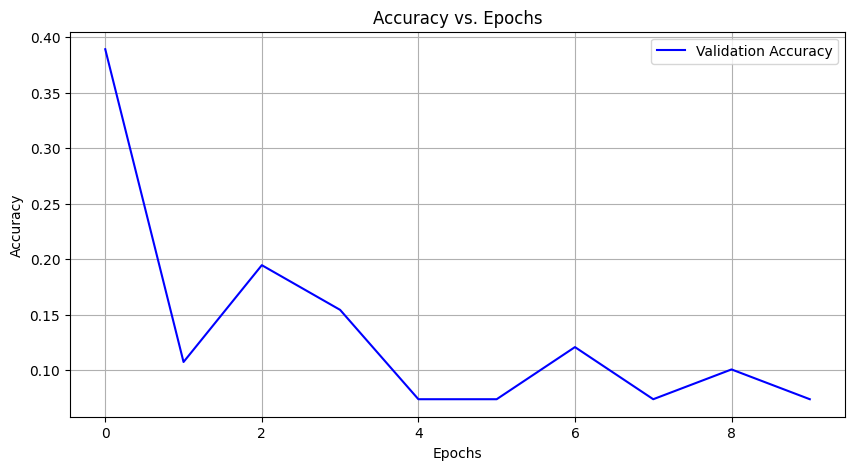

In [ ]:
plot_accuracy(epochs_vector, accuracy_vector, label='Validation Accuracy')

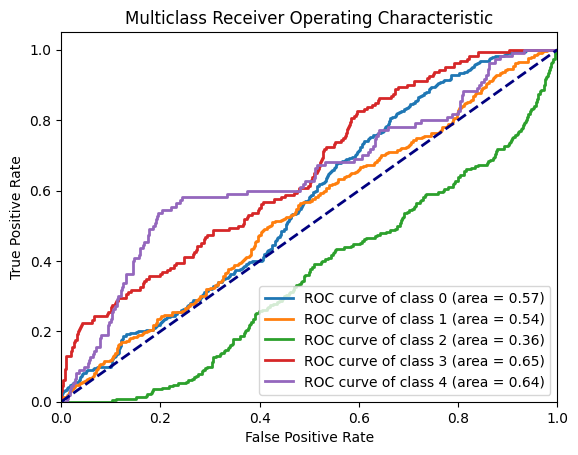

In [ ]:
true_labels = np.array(true_labels)
predictions = np.array(predictions)
plot_multiclass_roc_curve(true_labels, predictions, n_classes=num_classes)  # Set n_classes to your number of classes


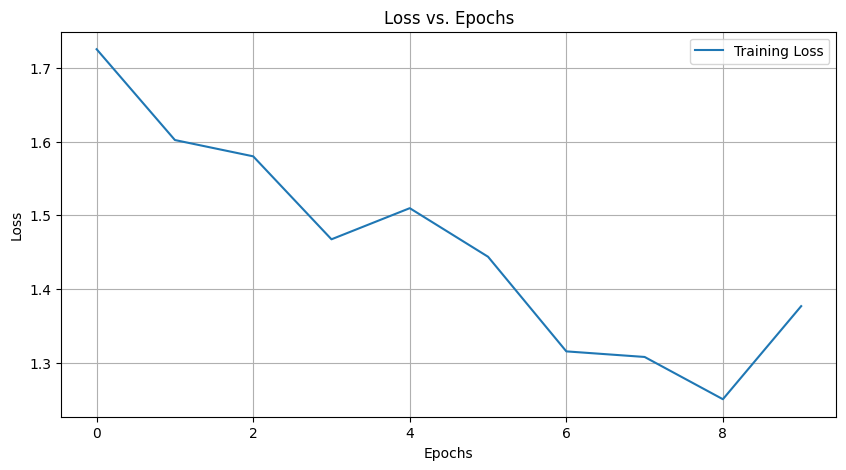

In [ ]:
plot_loss(loss_vector, epochs_vector)

À partir de ces graphiques, nous pouvons conclure que pour un problème Few-Shot, le pré-entraînement est extrêmement important pour obtenir les résultats souhaités. L'exactitude et la perte ne montrent aucune amélioration, elles semblent même se détériorer avec l'évolution. On peut supposer qu'il faudrait probablement beaucoup plus d'itérations pour atteindre un niveau de performance satisfaisant, ce qui serait difficile compte tenu du surapprentissage lié à un nombre élevé d'epochs. On note également que la courbe ROC se rapproche de la diagonale pour toutes les classes (même pour certains cas où elle est en dessous), ce qui ne représente pas une bonne performance.

# Using TIMM Library


Epoch 1, Loss: 1.5650493860244752
Epoch 2, Loss: 0.9827071189880371
Epoch 3, Loss: 0.9375324785709381
Epoch 4, Loss: 1.0460992693901061
Epoch 5, Loss: 0.891700804233551
Epoch 6, Loss: 0.5266727447509766
Epoch 7, Loss: 0.3180518954992294
Epoch 8, Loss: 0.49623828530311587
Epoch 9, Loss: 0.5915324375033378
Epoch 10, Loss: 0.7343076050281525


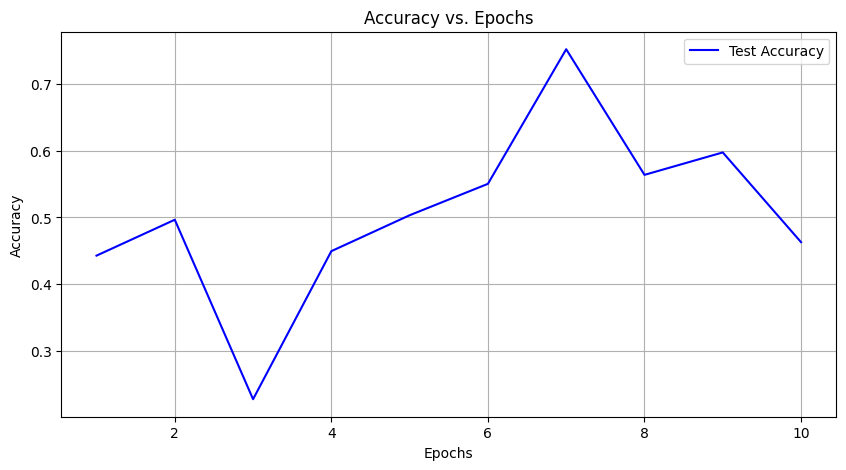

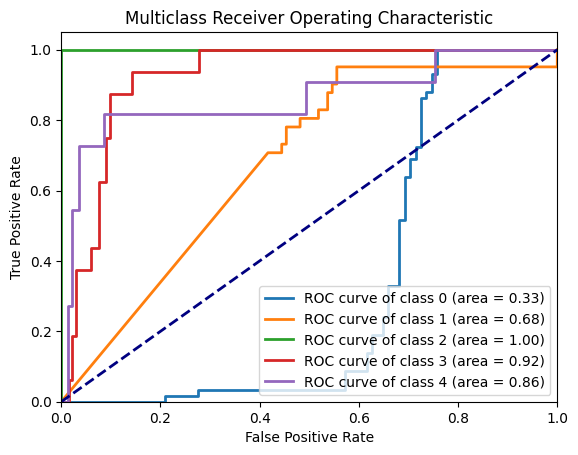

In [ ]:
# Initialize the model with custom weights and number of classes
weights = ResNet50_Weights.SENTINEL2_RGB_SECO
class_num = 5  # Replace with the actual number of classes in your dataset
in_chans = weights.meta["in_chans"]

model = timm.create_model("resnet50", pretrained=False, in_chans=in_chans, num_classes=class_num)
model.load_state_dict(weights.get_state_dict(progress=True), strict=False)

# Assuming CUDA is available, move model to GPU
model = model.cuda()

# # Data Preparation: Adjust paths and transforms as per your dataset
# train_transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     # Add any other dataset-specific transforms (e.g., normalization)
# ])

# train_dataset = ImageFolder(root='/path/to/train/data', transform=train_transform)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
loss_vector = []
accuracy_vector = []
epochs_vector = [i for i in range(1, num_epochs + 1)]
true_labels = np.array([])
predictions = np.array([]).reshape(0, num_classes)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    loss_vector.append(running_loss / len(train_loader))
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}')

    # Continue from your existing training loop
    # ...

    model.eval()

    # Reset the lists for evaluation phase
    true_labels = []
    predictions = []

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Accumulate true labels and predictions for ROC curve
            true_labels.extend(labels.cpu().numpy())
            probabilities = torch.softmax(outputs, dim=1)
            predictions.extend(probabilities.cpu().numpy())

    # Calculate overall accuracy
    epoch_accuracy = correct / total if total > 0 else 0
    accuracy_vector.append(epoch_accuracy)

# Plotting the accuracy graph
plot_accuracy(epochs_vector, accuracy_vector, label='Test Accuracy')

# Convert lists to Numpy arrays for ROC curve plotting
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Plot the ROC curve
plot_multiclass_roc_curve(true_labels, predictions, class_num)

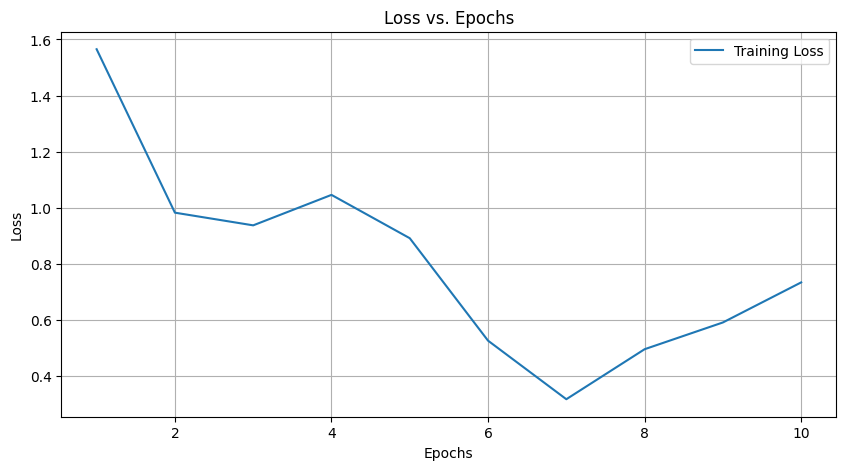

In [ ]:
plot_loss(loss_vector, epochs_vector)

Utiliser les poids pré-entraînés d'une ResNet50 pour un modèle de few-shot learning avec des données satellitaires améliore la performance en profitant de l'apprentissage transféré, en extrayant des caractéristiques générales utiles, en réduisant le risque de surajustement, et en économisant du temps et des ressources. Cela permet une adaptation spécifique aux images satellitaires pour détecter des régions en France, malgré certains défis d'ajustement aux caractéristiques uniques de ces images.

# Modèle ResNet50 avec learning rate optimisation

Jusqu'à présent, les hyperparamètres des modèles n'ont pas été discutés. Dans cette section, nous allons explorer le taux d'apprentissage et le nombre d'images par classe utilisées pour le Few Shot. Nous commençons par réécrire la fonction d'entraînement du modèle pour obtenir un contrôle plus fin sur certains paramètres. Ensuite, nous évaluons les performances du modèle sur les bases de données d'entraînement et de test avec l'évolution des époques avec un taux d'apprentissage de 0,03.

In [ ]:
from copy import deepcopy

In [ ]:
# Fonction pour entraîner un modèle sur une tâche de classification multilabel avec early stopping.
def train_model_multilabel(model, nlabel, trainloader, valloader, criterion, optimizer, scheduler, num_epochs=1, patience=5):

    # Listes pour enregistrer les performances et les pertes
    train_perf = []
    valid_perf = []
    train_losses = []
    valid_losses = []

   # Sauvegarde des meilleures performances et pertes
    best_weights = None
    best_train_loss = float('inf')
    best_valid_loss = float('inf')

    # Meilleure perte pour l'early stopping
    best_epoch_loss = float('inf')


    # Itération sur les époques
    num_epochs = 10
    loss_vector = []
    accuracy_vector = []
    epochs_vector = [i for i in range(num_epochs)]
    true_labels = []
    predictions = []

    # Étape d'apprentissage
    for epoch in range(num_epochs):
        model.train()
        iter = 0
        # print("Epoch {}".format(epoch))

        #Learning step
        epoch_train_loss = 0.0 # Pour calculer la perte moyenne de l'époque
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda() # Transfert des données sur GPU

            mespredictions = model(inputs) # Prédiction du modèle
            train_loss = criterion(mespredictions, labels) # Calcul de la perte
            optimizer.zero_grad() # Réinitialisation des gradients
            train_loss.backward() # Rétropropagation
            optimizer.step() # Mise à jour des poids

            if random.randint(0,20) == 0: # Affichage occasionnel de la perte
            # if True:
                print(iter, "train loss =", train_loss)

            iter += 1
            if train_loss.item() > 0 and train_loss.item() < best_train_loss: # Mise à jour de la meilleure perte d'entraînement
                best_train_loss = train_loss.item()

            epoch_train_loss += train_loss.item() # Accumulation de la perte de l'époque
        average_epoch_train_loss = epoch_train_loss / len(train_loader) # Calcul de la perte moyenne de l'époque
        train_losses.append(best_train_loss) # Ajout de la perte à la liste

        # Étape de validation
        total = 0
        correct = 0
        model.eval() # Passage du modèle en mode évaluation
        epoch_valid_loss = 0.0
        for inputs, labels in valloader:
            inputs, labels = inputs.cuda(), labels.cuda() # Transfert des données sur GPU
            with torch.no_grad(): # Désactivation du calcul de gradient
                outputs = model(inputs) # Prédiction du modèle
            _,pred = outputs.max(1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            valid_loss = criterion(outputs, labels) # Calcul de la perte de validation
            if valid_loss.item() > 0 and valid_loss.item() < best_valid_loss: # Mise à jour des meilleurs poids et de la perte de validation
                    best_valid_loss = valid_loss.item()
                    best_weights = deepcopy(model.state_dict())
            epoch_valid_loss += valid_loss.item() # Accumulation de la perte de validation

        average_epoch_valid_loss = epoch_valid_loss / len(valloader) # Calcul de la perte moyenne de validation
        valid_losses.append(best_valid_loss) # Ajout de la perte à la liste
        valid_perf.append(correct/total)

        # Vérification de la condition d'early stopping
        if average_epoch_valid_loss < best_epoch_loss:
            best_epoch_loss = average_epoch_valid_loss
            current_patience = 0
        else:
            current_patience += 1
            if current_patience >= patience:
                print(f"Early stopping. No improvement for {patience} epochs.")
                current_patience = 0
                #break #stop training

        print("Epoch {}".format(epoch), 'Train: ', average_epoch_train_loss,
              "Test: ", average_epoch_valid_loss)
    return model, train_perf, valid_perf, train_losses, valid_losses, best_weights


Epoch 0 Train:  3.1646474838256835 Test:  1.5607424605452152e+16
Epoch 1 Train:  2.0312554836273193 Test:  9765978572.8
Epoch 2 Train:  1.7937236547470092 Test:  13568682.259375
Epoch 3 Train:  1.64177348613739 Test:  127871.69381306967
Epoch 4 Train:  1.525557017326355 Test:  6780.778647759556
Epoch 5 Train:  1.4284756898880004 Test:  495.3761677324772
Epoch 6 Train:  1.424784815311432 Test:  45.64646317263444
Epoch 7 Train:  1.8102410793304444 Test:  8.374371545106987
Epoch 8 Train:  1.2696463346481324 Test:  186.4237907042106
Epoch 9 Train:  1.2704546689987182 Test:  1127.1846812695264


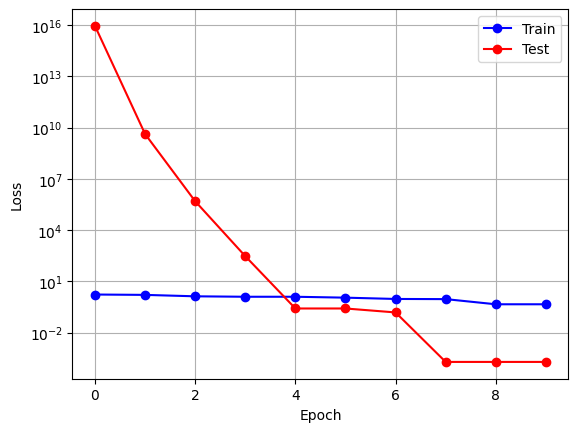

In [ ]:
# Configuration de l'optimiseur et du critère de perte pour le modèle
optimizer = optim.Adam(model.parameters(), lr=0.03) # Utilise l'optimiseur Adam avec un taux d'apprentissage de 0.03
criterion = nn.CrossEntropyLoss() # Utilise la perte d'entropie croisée pour la classification
n_label = 5 # Nombre de labels dans le dataset

# Entraînement du modèle avec la fonction train_model_multilabel
model.load_state_dict(weights.get_state_dict(), strict=False)
model, train_perf, test_perf, train_losses, valid_losses, best_weights = train_model_multilabel(model, n_label, train_loader, test_loader, criterion, optimizer, scheduler=0, num_epochs=10)
epoch_array = np.linspace(0,9,10)
# Tracé des courbes de perte pour l'entraînement et la validation
plt.plot(epoch_array, train_losses, marker='o', linestyle='-', color='b', label='Train')
plt.plot(epoch_array, valid_losses, marker='o', linestyle='-', color='r', label='Test')
plt.yscale('log')
plt.title('')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

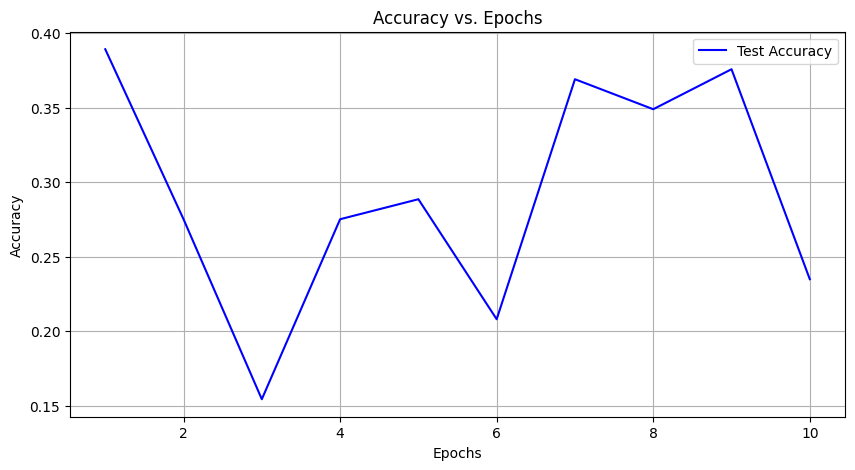

In [ ]:
plot_accuracy(epochs_vector, test_perf, label='Test Accuracy')

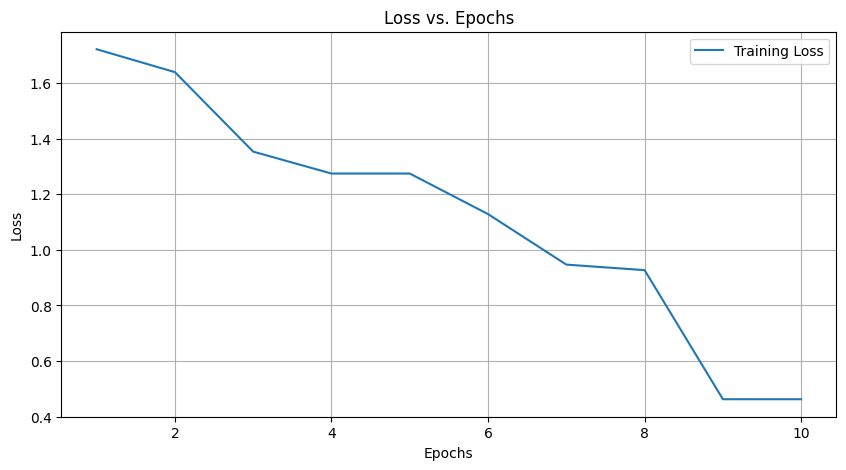

In [ ]:
plot_loss(train_losses, epochs_vector)

Il est possible de remarquer que le modèle a un taux d'évolution satisfaisant, mais son exactitude n'est pas encore suffisante. Par conséquent, nous allons entraîner le même modèle avec des taux d'apprentissage différents afin d'optimiser ce hyperparamètre et obtenir une exactitude plus élevée.

In [ ]:
# Loop for with different learning rates an select the best
learnRateArr = np.logspace(-5.0, 0.0, num=20)
n_label = 5

criterion = nn.CrossEntropyLoss()
bestTrainLossArr = []
bestValidLossArr = []
bestWeightsArr = []

for idx, lr in enumerate(learnRateArr[::-1]):
    model.load_state_dict(weights.get_state_dict(), strict=False)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model, train_perf, test_perf, train_losses, valid_losses, best_weights = train_model_multilabel(model, n_label, train_loader, test_loader, criterion, optimizer, scheduler=0, num_epochs=8)
    bestTrainLossArr.append(min(train_losses))
    bestValidLossArr.append(min(valid_losses))
    bestWeightsArr.append(best_weights)
    # print(len(bestTrainLossArr), bestTrainLossArr)
    # print("Lowest Train losses =", min(train_losses), "Learning Rate:", lr)

print(bestTrainLossArr)

# Plotting
plt.plot(learnRateArr, bestTrainLossArr, marker='o', linestyle='-', color='b', label='Train')
plt.plot(learnRateArr, bestValidLossArr, marker='o', linestyle='-', color='r', label='Validation')
plt.xscale('log')
plt.yscale('log')  # Use a logarithmic scale for better visualization if learning rates vary widely
plt.title('Best Loss vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Best Training Loss')
plt.legend()
plt.grid(True)
plt.show()


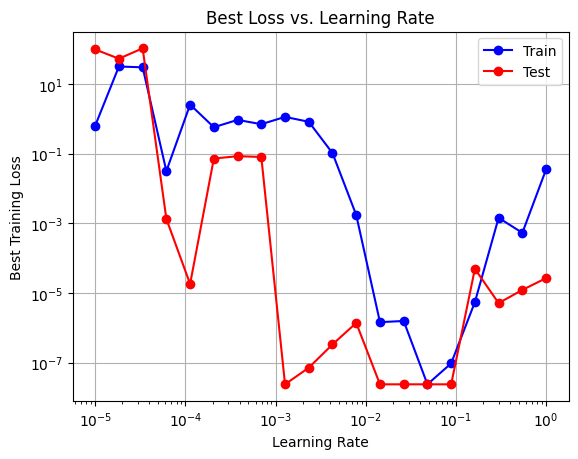

In [ ]:
# Plotting
plt.plot(learnRateArr, bestTrainLossArr, marker='o', linestyle='-', color='b', label='Train')
plt.plot(learnRateArr, bestValidLossArr, marker='o', linestyle='-', color='r', label='Test')
plt.xscale('log')
plt.yscale('log')  # Use a logarithmic scale for better visualization if learning rates vary widely
plt.title('Best Loss vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Best Training Loss')
plt.legend()
plt.grid(True)
plt.show()

À partir du graphique ci-dessus, il est possible de conclure que le taux d'apprentissage optimal se situe entre 0,01 et 0,1. Par la suite, nous allons calculer l'exactitude de chacun et tracer la matrice de confusion du modèle avec la meilleure performance.

In [ ]:
from sklearn.metrics import confusion_matrix

def calc_confusion_mat(model, testloader, n_class):
    model.eval()
    cm = np.zeros((5,5), dtype=int) ## metre a zero

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.cuda(), targets.cuda()
            outputs = model(inputs)
            _,pred = outputs.max(1)
            cm += confusion_matrix(pred.cpu().numpy(),
                                targets.cpu().numpy(),
                                labels=list(range(n_class)))
    accuracy = 0
    total = 0
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            total += cm[i][j]
    accuracy = np.trace(cm)/total

    return cm, accuracy


for i, state in enumerate(bestWeightsArr):
    eval_model = timm.create_model("resnet50", in_chans=in_chans, num_classes=class_num).cuda()
    eval_model.load_state_dict(state)
    cm, accuracy = calc_confusion_mat(eval_model, test_loader, n_class=5)
    # print(cm)
    print(i,"accuracy:", accuracy)



0 accuracy: 0.3087248322147651
1 accuracy: 0.15436241610738255
2 accuracy: 0.2751677852348993
3 accuracy: 0.31543624161073824
4 accuracy: 0.3825503355704698
5 accuracy: 0.5167785234899329
6 accuracy: 0.5637583892617449
7 accuracy: 0.5167785234899329
8 accuracy: 0.5369127516778524
9 accuracy: 0.3087248322147651
10 accuracy: 0.35570469798657717
11 accuracy: 0.6040268456375839
12 accuracy: 0.6442953020134228
13 accuracy: 0.6174496644295302
14 accuracy: 0.6912751677852349
15 accuracy: 0.8322147651006712
16 accuracy: 0.7785234899328859
17 accuracy: 0.6778523489932886
18 accuracy: 0.6644295302013423
19 accuracy: 0.5973154362416108


In [ ]:
    eval_model.load_state_dict(bestWeightsArr[-5])
    cm, accuracy = calc_confusion_mat(eval_model, test_loader, n_class=5)
    print(cm)
    print(accuracy)

[[46  0  0  2  0]
 [ 8 40  1  0  0]
 [ 0  0 20  0  0]
 [ 2  1  0  7  0]
 [ 2  0  2  7 11]]
0.8322147651006712


Ce résultat montre l'importance de l'optimisation des hyperparamètres du modèle. Nous avons pu atteindre une précision de 83 % sur un problème Few-Shot 5-way-5-shot. Nous allons ensuite analyser comment le nombre d'images disponibles par classe affecte les performances du modèle.

Epoch 0 Train:  15.277607917785645 Test:  444012140.0
Epoch 1 Train:  35.23875427246094 Test:  39789753951846.4
Epoch 2 Train:  122.58392333984375 Test:  29643797963298.133
Epoch 3 Train:  17.75661849975586 Test:  23730139465864.535
Epoch 4 Train:  9.470385551452637 Test:  5798162473506.134
0 train loss = tensor(3.1880, device='cuda:0', grad_fn=<NllLossBackward0>)
Early stopping. No improvement for 5 epochs.
Epoch 5 Train:  3.1879565715789795 Test:  1677584057412.2666
Epoch 6 Train:  0.017581136897206306 Test:  290738327825.06665
Epoch 7 Train:  0.022150326520204544 Test:  56490869691.73333
Epoch 8 Train:  0.18448854982852936 Test:  13244756838.4
Epoch 9 Train:  0.009969515725970268 Test:  3654594449.0666666
Epoch 0 Train:  42.652421379089354 Test:  697993194827502.9
0 train loss = tensor(56.5562, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 1 Train:  34.07863178253174 Test:  5871748909.066667
Epoch 2 Train:  21.3812171459198 Test:  10161925.252083333
Epoch 3 Train:  12.924597358

ValueError: x and y must have same first dimension, but have shapes (8,) and (10,)

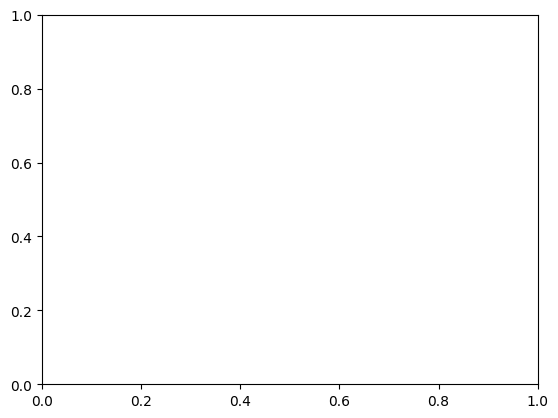

In [ ]:
# Loop for with different n-shots
n_label = 5
num_epochs = 8

n_shot_arr = [1, 5, 10, 20, 50]
criterion = nn.CrossEntropyLoss()
accuracies_list = []

for idx, n_shot in enumerate(n_shot_arr):
    # Pour les données d'apprentissage
    train_dataset = FlairDataset(txt_files=[train_paths], trsf=train_trsf, k_per_class=n_shot)
    train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=num_workers)
    model.load_state_dict(weights.get_state_dict(), strict=False)
    optimizer = optim.Adam(model.parameters(), lr=0.015)
    model, train_perf, test_perf, train_losses, valid_losses, best_weights = train_model_multilabel(model, n_label, train_loader, test_loader, criterion, optimizer, scheduler=0, num_epochs=num_epochs)
    accuracies_list.append(test_perf)

print(bestTrainLossArr)

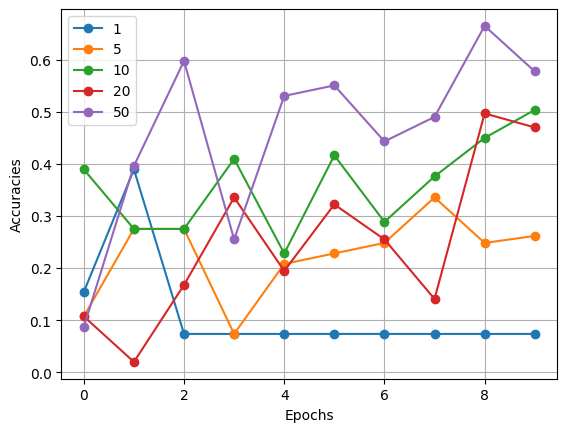

In [ ]:
num_epochs=10
for idx, acc in enumerate(accuracies_list):
    plt.plot(np.linspace(0,num_epochs-1, num_epochs), acc, marker='o', linestyle='-', label=n_shot_arr[idx])
plt.xlabel('Epochs')
plt.ylabel('Accuracies')
plt.legend()
plt.grid(True)
plt.show()

# Conclusion

En conclusion, notre étude comparative sur les modèles de machine learning pour un problème de classification d'images en few-shot learning a révélé des résultats distincts pour chaque approche testée.

1. **ResNet18 sans entraînement préalable ni poids** : Ce modèle a montré une performance relativement basse. Le manque d'entraînement préalable et l'absence de poids initiaux ont conduit à une capacité limitée de la ResNet18 à généraliser à partir d'un petit ensemble de données. Cela suggère que, pour des tâches de few-shot learning, partir de zéro peut ne pas être l'approche la plus efficace.

2. **ResNet50 avec poids pré-entraînés d'images de satellite** : L'utilisation de la ResNet50 pré-entraînée a nettement amélioré les résultats par rapport au premier modèle. Les poids pré-entraînés issus d'un ensemble de données de satellite ont fourni une base solide pour l'extraction de caractéristiques, ce qui a permis une meilleure identification et classification des images, malgré le nombre limité d'exemples d'entraînement.

3. **Optimisation de la ResNet50 avec ajustement du taux d'apprentissage** : Cette variante de la ResNet50, où le taux d'apprentissage a été optimisé par itération, a produit les résultats les plus prometteurs. L'ajustement dynamique du taux d'apprentissage a permis au modèle de s'adapter plus finement aux spécificités du jeu de données, aboutissant à une performance supérieure par rapport aux deux autres modèles. Cela souligne l'importance de l'ajustement fin des hyperparamètres dans les modèles de few-shot learning.

En résumé, les résultats démontrent l'efficacité de l'utilisation de modèles pré-entraînés et l'importance de l'optimisation des hyperparamètres, en particulier dans des contextes de few-shot learning où chaque ajustement peut avoir un impact significatif sur la performance du modèle.

#**Annexe : Tentative d'Implémentation de Modèles de Metalearning**

Dans cet annexe, nous souhaitons discuter d'une tentative parallèle entreprise dans le cadre de ce projet, qui impliquait l'implémentation de modèles de metalearning, considérés comme l'état de l'art pour les problèmes de few-shot learning. Les approches spécifiques que nous avons essayé d'inclure étaient les réseaux neuronaux Prototypical et MAML (Model-Agnostic Meta-Learning).

Malgré le potentiel de ces approches dans les problèmes de few-shot learning, nous avons rencontré des défis significatifs qui nous ont empêchés de conclure cette partie du projet à temps pour générer des résultats fiables. Les principales difficultés résidaient dans la complexité avancée des concepts de metalearning et les limitations de l'environnement de notebook utilisé pour l'implémentation et les expérimentations.

Au cours de ce processus, nous avons exploré des concepts fondamentaux de metalearning, tels que :

1. **Query Set** : Un ensemble de données utilisé pour tester la capacité de généralisation du modèle. Dans un épisode typique d'entraînement de metalearning, le modèle est d'abord entraîné sur un ensemble de support, puis testé sur un query set pour évaluer ses performances.

2. **Support Set** : Cet ensemble de données est utilisé pour l'entraînement initial dans chaque épisode de metalearning. Le modèle utilise cet ensemble pour apprendre et s'adapter rapidement à de nouvelles tâches.

3. **Concepts Approfondis du Metalearning** :
    - **Apprentissage Rapide** : La capacité du modèle à apprendre de nouvelles tâches rapidement avec peu de données.
    - **Généralisation entre Tâches** : L'aptitude du modèle à transférer l'apprentissage acquis d'une tâche à une autre.
    - **Équilibrage des Tâches** : La technique de gestion de diverses tâches simultanées, garantissant que le modèle ne se suradapte pas à une tâche spécifique.

En plus, une tentative d'implémentation d'un ensemble de données de validation, conformément aux bonnes pratiques en apprentissage automatique, a été entreprise dans le cadre de ce projet. Cependant, des difficultés ont émergé lors de l'intégration de cet ensemble de données avec d'autres ensembles fournis. Malgré nos efforts pour suivre les recommandations en matière de validation des modèles, l'interopérabilité avec d'autres jeux de données s'est révélée être un défi imprévu. Nous avons rencontré des obstacles techniques qui ont limité la fusion harmonieuse de ces ensembles, impactant ainsi la mise en œuvre de la validation.

Malheureusement, en raison de la nature avancée de ces concepts et des limitations techniques rencontrées, nous n'avons pas été capables de mettre en œuvre et d'évaluer adéquatement ces modèles dans les délais du projet. Nous continuons cependant à considérer le metalearning comme un domaine prometteur pour des recherches futures, en particulier dans les défis de few-shot learning, et prévoyons de reprendre ce travail dès que possible.